In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir "/content/spoken_digit/"
!cp "/content/drive/MyDrive/fiverr/Spoken_Digit_recognition/spoken_digit.zip" -d "/content/spoken_digit/"

In [3]:
!unzip "/content/spoken_digit/spoken_digit.zip"

Archive:  /content/spoken_digit/spoken_digit.zip
  inflating: data/9_F_12.wav         
  inflating: data/9_D_0.wav          
  inflating: data/8_F_36.wav         
  inflating: data/9_B_15.wav         
  inflating: data/8_E_5.wav          
  inflating: data/9_B_46.wav         
  inflating: data/8_F_30.wav         
  inflating: data/8_E_46.wav         
  inflating: data/8_F_10.wav         
  inflating: data/9_C_29.wav         
  inflating: data/9_C_22.wav         
  inflating: data/9_A_8.wav          
  inflating: data/9_C_13.wav         
  inflating: data/9_F_49.wav         
  inflating: data/9_E_38.wav         
  inflating: data/9_D_35.wav         
  inflating: data/9_E_6.wav          
  inflating: data/8_F_21.wav         
  inflating: data/9_E_24.wav         
  inflating: data/9_D_26.wav         
  inflating: data/8_F_33.wav         
  inflating: data/9_B_38.wav         
  inflating: data/9_D_43.wav         
  inflating: data/9_D_18.wav         
  inflating: data/9_B_2.wav          
 

In [4]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio 
from IPython.core.display import display

In [5]:
import os
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input
from tensorflow.keras.utils import Sequence
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adadelta
from tensorflow.keras.layers import BatchNormalization

In [6]:
AUDIO_PATH = "/content/data"

In [7]:
audio_files = []
labels = []
for file in os.listdir(AUDIO_PATH):
  label = file.split('_')[0]
  labels.append(int(label))
  audio_files.append(os.path.join(AUDIO_PATH, file))
  print(f"file name : {file}, Label: {file.split('_')[0]}")

file name : 4_A_4.wav, Label: 4
file name : 9_E_42.wav, Label: 9
file name : 4_F_40.wav, Label: 4
file name : 0_B_35.wav, Label: 0
file name : 6_D_40.wav, Label: 6
file name : 6_E_31.wav, Label: 6
file name : 5_C_17.wav, Label: 5
file name : 4_E_34.wav, Label: 4
file name : 2_A_1.wav, Label: 2
file name : 8_D_48.wav, Label: 8
file name : 2_B_21.wav, Label: 2
file name : 7_A_16.wav, Label: 7
file name : 5_E_43.wav, Label: 5
file name : 5_F_45.wav, Label: 5
file name : 1_E_14.wav, Label: 1
file name : 3_D_13.wav, Label: 3
file name : 2_B_47.wav, Label: 2
file name : 6_A_34.wav, Label: 6
file name : 6_E_18.wav, Label: 6
file name : 3_B_11.wav, Label: 3
file name : 3_A_21.wav, Label: 3
file name : 8_E_15.wav, Label: 8
file name : 2_F_30.wav, Label: 2
file name : 1_B_29.wav, Label: 1
file name : 6_B_48.wav, Label: 6
file name : 4_B_40.wav, Label: 4
file name : 7_E_32.wav, Label: 7
file name : 3_A_29.wav, Label: 3
file name : 2_A_21.wav, Label: 2
file name : 9_D_47.wav, Label: 9
file name : 

In [8]:
def display_audio(indx = 0):
  file_path = audio_files[indx]
  label = labels[indx]
  print("Data Label: ", label)
  display(Audio(file_path))

  # print(file_path)


In [9]:
display_audio(150)

Data Label:  8


(5632,)


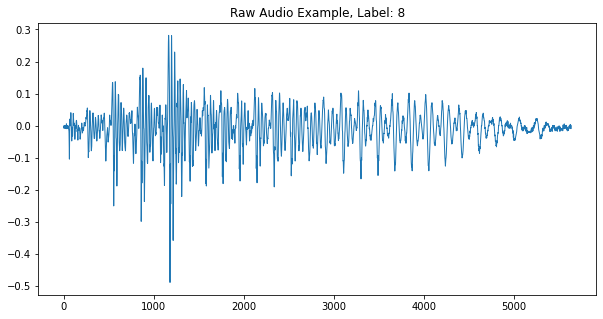

In [10]:
y, sr = librosa.load(audio_files[150])
if len(y)> 0: 
  y, _ = librosa.effects.trim(y, top_db = 10)
print(y.shape)
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title=f'Raw Audio Example, Label: {labels[150]}',)
plt.show()

In [11]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

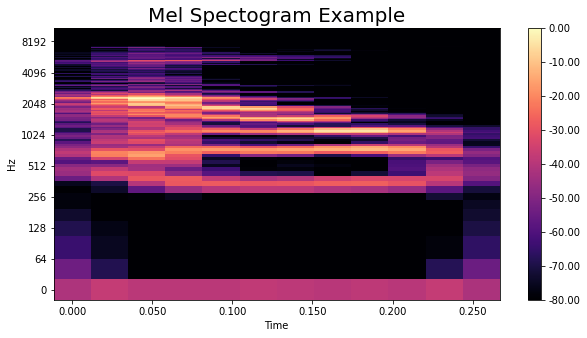

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [13]:
S_db_mel.shape, S_db_mel

((256, 12),
 array([[-41.655037, -37.31385 , -39.168186, ..., -39.627308, -37.31774 ,
         -41.964928],
        [-53.853798, -68.61097 , -80.      , ..., -80.      , -67.96448 ,
         -54.53302 ],
        [-64.33795 , -75.02074 , -80.      , ..., -80.      , -78.27982 ,
         -66.114746],
        ...,
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ]], dtype=float32))

In [14]:
samples = 10000
def process_audio(file):
  y, sr = librosa.load(file)
  if len(y)> 0: 
    y, _ = librosa.effects.trim(y, top_db = 10)

  #Trim if audio length > samples 
  if len(y) > samples: 
      y = y[0:0+samples]
      
  #Else pad blanks if shorter 
  else: 
      padding = samples - len(y)
      offset = padding // 2
      y = np.pad(y, (offset, samples - len(y) - offset), mode = 'constant')
  

  S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128,)
  S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

  return S_db_mel

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
y = np.array(labels).reshape(-1,1)
encoder.fit(y)
y= encoder.transform(y).toarray()
print(y[:5])
# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(audio_files, y, test_size=0.2, random_state=42)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [16]:
class TrainDataSequence(tf.keras.utils.Sequence):

  def __init__(self, x = X_train, y = y_train,  batch_size = 32):
    self.x, self.y = x, y
    self.batch_size = batch_size


  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) *
    self.batch_size]

    batch_y = self.y[idx * self.batch_size:(idx + 1) *
    self.batch_size]

    X = []
    Y = []
    for indx, audio in enumerate(batch_x):
      mel_spec = process_audio(audio) 
      X.append(mel_spec)
      Y.append(batch_y[indx])

    return np.array(X), np.array(Y)


In [17]:
class TestDataSequence(tf.keras.utils.Sequence):
  def __init__(self, x =X_test, y = y_test,  batch_size = 32):
    self.x, self.y = x, y
    self.batch_size = batch_size


  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) *
    self.batch_size]

    batch_y = self.y[idx * self.batch_size:(idx + 1) *
    self.batch_size]

    X = []
    Y = []
    for indx, audio in enumerate(batch_x):
      mel_spec = process_audio(audio) 
      X.append(mel_spec)
      Y.append(batch_y[indx])

    return np.array(X), np.array(Y)

In [18]:
train_sequence =  TrainDataSequence()
test_sequence = TestDataSequence()
# print(*train_sequence)

In [22]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 2), activation='relu', input_shape=(128,15,1),))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(16, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

In [23]:
print("[INFO] compiling model...")
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics="accuracy")
model.summary()

[INFO] compiling model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 14, 32)       224       
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 12, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 6, 64)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 4, 32)         18464     
                                                                 
 conv2d_7 (Conv2D)           (None, 59, 3, 16)         2064      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 1, 16)        0         
 2D)                        

In [24]:
history = model.fit(train_sequence, validation_data = test_sequence, epochs = 30, verbose=1)

Epoch 1/30
75/75 [==============================] - 39s 481ms/step - loss: 2.3211 - accuracy: 0.1121 - val_loss: 2.1925 - val_accuracy: 0.1967
Epoch 2/30
75/75 [==============================] - 31s 410ms/step - loss: 2.1576 - accuracy: 0.1967 - val_loss: 1.9314 - val_accuracy: 0.2817
Epoch 3/30
75/75 [==============================] - 32s 429ms/step - loss: 1.8631 - accuracy: 0.3200 - val_loss: 1.5298 - val_accuracy: 0.4850
Epoch 4/30
75/75 [==============================] - 36s 477ms/step - loss: 1.5827 - accuracy: 0.4375 - val_loss: 1.1080 - val_accuracy: 0.6950
Epoch 5/30
75/75 [==============================] - 33s 444ms/step - loss: 1.1643 - accuracy: 0.5879 - val_loss: 0.7433 - val_accuracy: 0.7883
Epoch 6/30
75/75 [==============================] - 30s 400ms/step - loss: 0.9122 - accuracy: 0.6846 - val_loss: 0.6073 - val_accuracy: 0.8183
Epoch 7/30
75/75 [==============================] - 35s 474ms/step - loss: 0.7397 - accuracy: 0.7296 - val_loss: 0.5378 - val_accuracy: 0.8300